<a href="https://colab.research.google.com/github/arizkyrahman/rizky_rahman_house_prices/blob/main/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

In [93]:
# Data Analytics Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Machine Learning Libraries
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from math import ceil

# Update some default parameters for plotting throughout the notebook
plt.rcParams.update({'font.size': 12, 'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':15, 'axes.titlesize':20})

In [94]:
# Load Data
Xy = pd.read_csv("/content/drive/MyDrive/train.csv", index_col='Id')
X_test = pd.read_csv("/content/drive/MyDrive/test.csv", index_col='Id')

# Remove rows with missing target
Xy = Xy.dropna(axis=0, subset=['SalePrice'])

# Separate target from predictors
X = Xy.drop(['SalePrice'], axis=1)
y = Xy.SalePrice

# Summary
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

info = pd.DataFrame(X.dtypes, columns=['Dtype'])
info['Unique'] = X.nunique().values
info['Null'] = X.isnull().sum().values

info

Dtype  Unique  Null
MSSubClass       int64      15     0
MSZoning        object       5     0
LotFrontage    float64     110   259
LotArea          int64    1073     0
Street          object       2     0
Alley           object       2  1369
LotShape        object       4     0
LandContour     object       4     0
Utilities       object       2     0
LotConfig       object       5     0
LandSlope       object       3     0
Neighborhood    object      25     0
Condition1      object       9     0
Condition2      object       8     0
BldgType        object       5     0
HouseStyle      object       8     0
OverallQual      int64      10     0
OverallCond      int64       9     0
YearBuilt        int64     112     0
YearRemodAdd     int64      61     0
RoofStyle       object       6     0
RoofMatl        object       8     0
Exterior1st     object      15     0
Exterior2nd     object      16     0
MasVnrType      object       4     8
MasVnrArea     float64     327     8
ExterQual       object       4     0
ExterCond       object       5     0
Foundation      object       6     0
BsmtQual        object       4    37
BsmtCond        object       4    37
BsmtExposure    object       4    38
BsmtFinType1    object       6    37
BsmtFinSF1       int64     637     0
BsmtFinType2    object       6    38
BsmtFinSF2       int64     144     0
BsmtUnfSF        int64     780     0
TotalBsmtSF      int64     721     0
Heating         object       6     0
HeatingQC       object       5     0
CentralAir      object       2     0
Electrical      object       5     1
1stFlrSF         int64     753     0
2ndFlrSF         int64     417     0
LowQualFinSF     int64      24     0
GrLivArea        int64     861     0
BsmtFullBath     int64       4     0
BsmtHalfBath     int64       3     0
FullBath         int64       4     0
HalfBath         int64       3     0
BedroomAbvGr     int64       8     0
KitchenAbvGr     int64       4     0
KitchenQual     object       4     0
TotRmsAbvGrd     int64      12     0
Functional      object       7     0
Fireplaces       int64       4     0
FireplaceQu     object       5   690
GarageType      object       6    81
GarageYrBlt    float64      97    81
GarageFinish    object       3    81
GarageCars       int64       5     0
GarageArea       int64     441     0
GarageQual      object       5    81
GarageCond      object       5    81
PavedDrive      object       3     0
WoodDeckSF       int64     274     0
OpenPorchSF      int64     202     0
EnclosedPorch    int64     120     0
3SsnPorch        int64      20     0
ScreenPorch      int64      76     0
PoolArea         int64       8     0
PoolQC          object       3  1453
Fence           object       4  1179
MiscFeature     object       4  1406
MiscVal          int64      21     0
MoSold           int64      12     0
YrSold           int64       5     0
SaleType        object       9     0
SaleCondition   object       6     0

In [95]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [96]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Correlation between features and target on heatmap

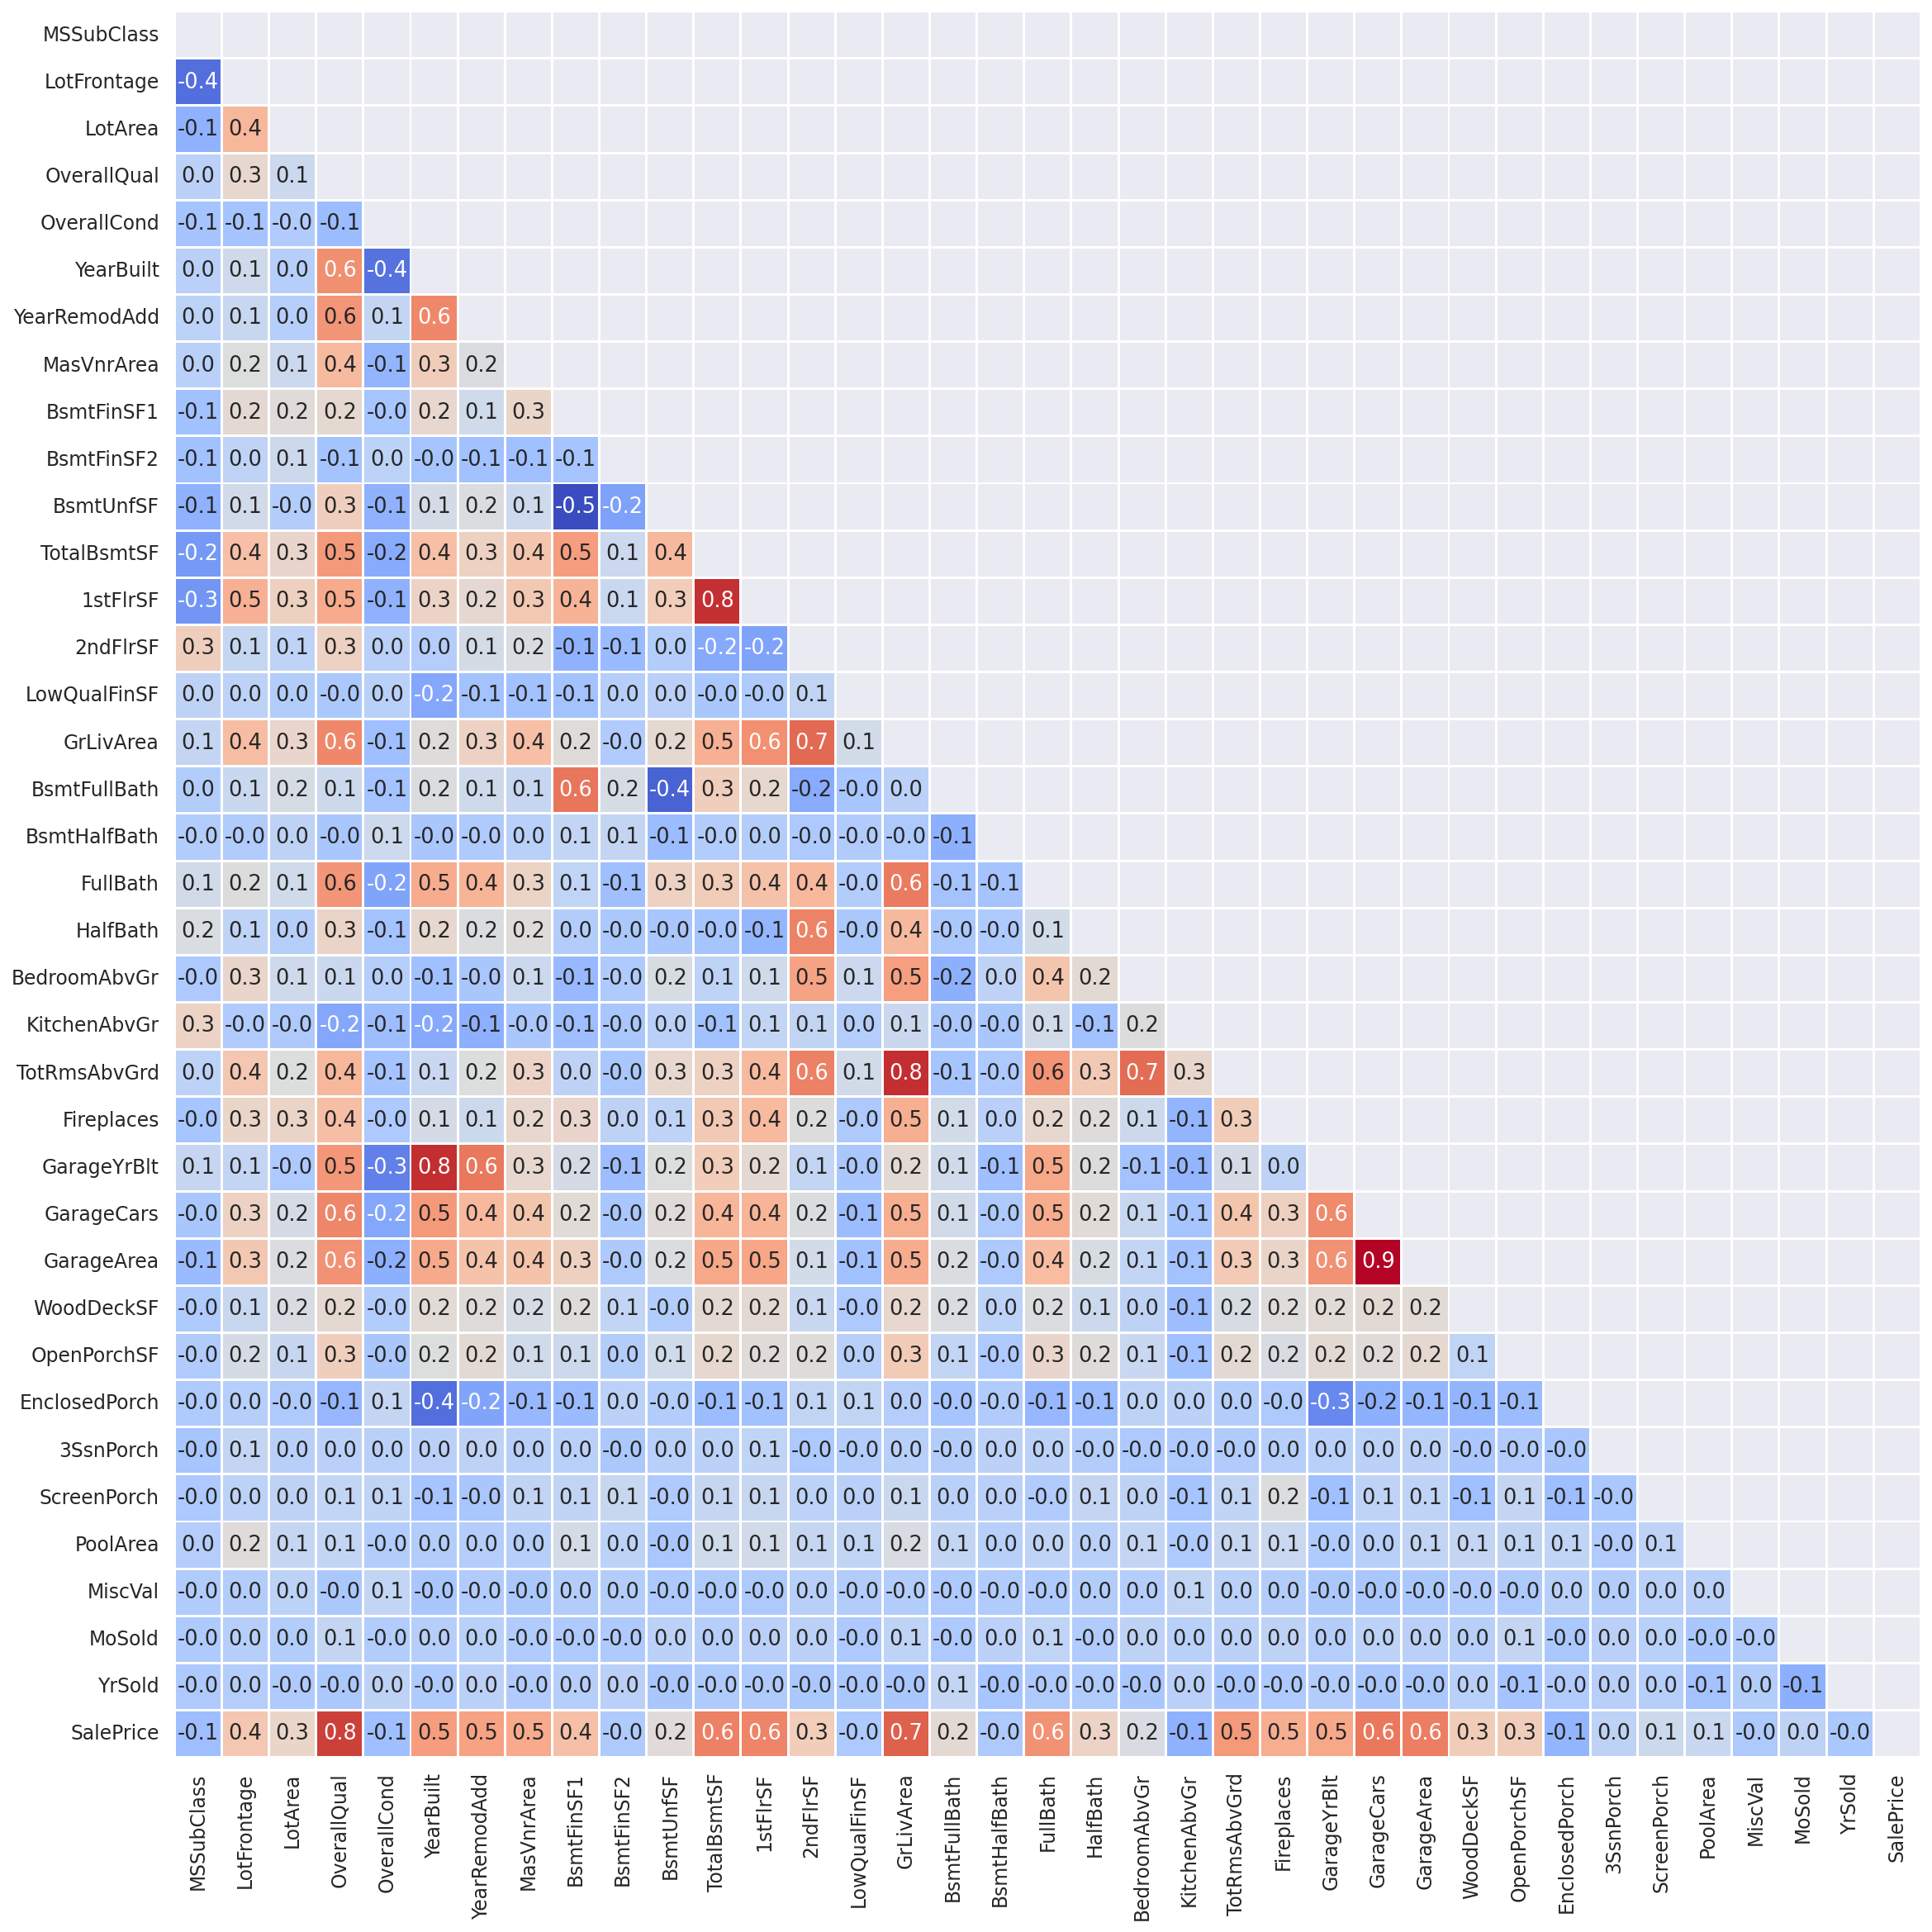

In [97]:
correlation_matrix = Xy.corr()

# Returns copy of array with upper part of the triangle (which will be masked/hidden)
mask = np.triu(correlation_matrix.corr())

sns.set(font_scale=1.1)
plt.figure(figsize=(20, 20), dpi=140)
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', 
            square=True, mask=mask, linewidths=1, cbar=False)

plt.show()

## Data Cleaning

In [98]:
# Total rows/observations/houses in Training data and Test data
print(len(X),len(X_test))

1460 1459


Remove the columns with more than half missing values

In [99]:
# Making function so that we can reuse it in later stages as well
def show_null_values(X, X_test):
    # Missing values in each column of Training and Testing data
    null_values_train = X.isnull().sum()
    null_values_test = X_test.isnull().sum()

    # Making DataFrame for combining training and testing missing values
    null_values = pd.DataFrame(null_values_train)
    null_values['Test Data'] = null_values_test.values
    null_values.rename(columns = {0:'Train Data'}, inplace = True)

    # Showing only columns having missing values and sorting them
    null_values = null_values.loc[(null_values['Train Data']!=0) | (null_values['Test Data']!=0)]
    null_values = null_values.sort_values(by=['Train Data','Test Data'],ascending=False)
    
    print("Total miising values:",null_values.sum(),sep='\n')
    
    return null_values

show_null_values(X, X_test)

Total miising values:
Train Data    6965
Test Data     7000
dtype: int64


Train Data  Test Data
PoolQC              1453       1456
MiscFeature         1406       1408
Alley               1369       1352
Fence               1179       1169
FireplaceQu          690        730
LotFrontage          259        227
GarageYrBlt           81         78
GarageFinish          81         78
GarageQual            81         78
GarageCond            81         78
GarageType            81         76
BsmtExposure          38         44
BsmtFinType2          38         42
BsmtCond              37         45
BsmtQual              37         44
BsmtFinType1          37         42
MasVnrType             8         16
MasVnrArea             8         15
Electrical             1          0
MSZoning               0          4
Utilities              0          2
BsmtFullBath           0          2
BsmtHalfBath           0          2
Functional             0          2
Exterior1st            0          1
Exterior2nd            0          1
BsmtFinSF1             0          1
BsmtFinSF2             0          1
BsmtUnfSF              0          1
TotalBsmtSF            0          1
KitchenQual            0          1
GarageCars             0          1
GarageArea             0          1
SaleType               0          1

In [100]:
# Columns with missing values in more than half number of rows
null_cols = [col for col in X.columns if X[col].isnull().sum() > len(X)/2]

null_cols

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [101]:
X.drop(null_cols,axis=1,inplace=True)
X_test.drop(null_cols,axis=1,inplace=True)

In [102]:
# Total missing values after removing columns with more than half missing values
print("Total missing values:")
print("Training data\t",X.isnull().sum().sum())
print("Testing data\t",X_test.isnull().sum().sum())

Total missing values:
Training data	 1558
Testing data	 1615


Data Visualization (Categorical Data)

In [103]:
object_cols = X.select_dtypes('object').columns
len(object_cols)

39

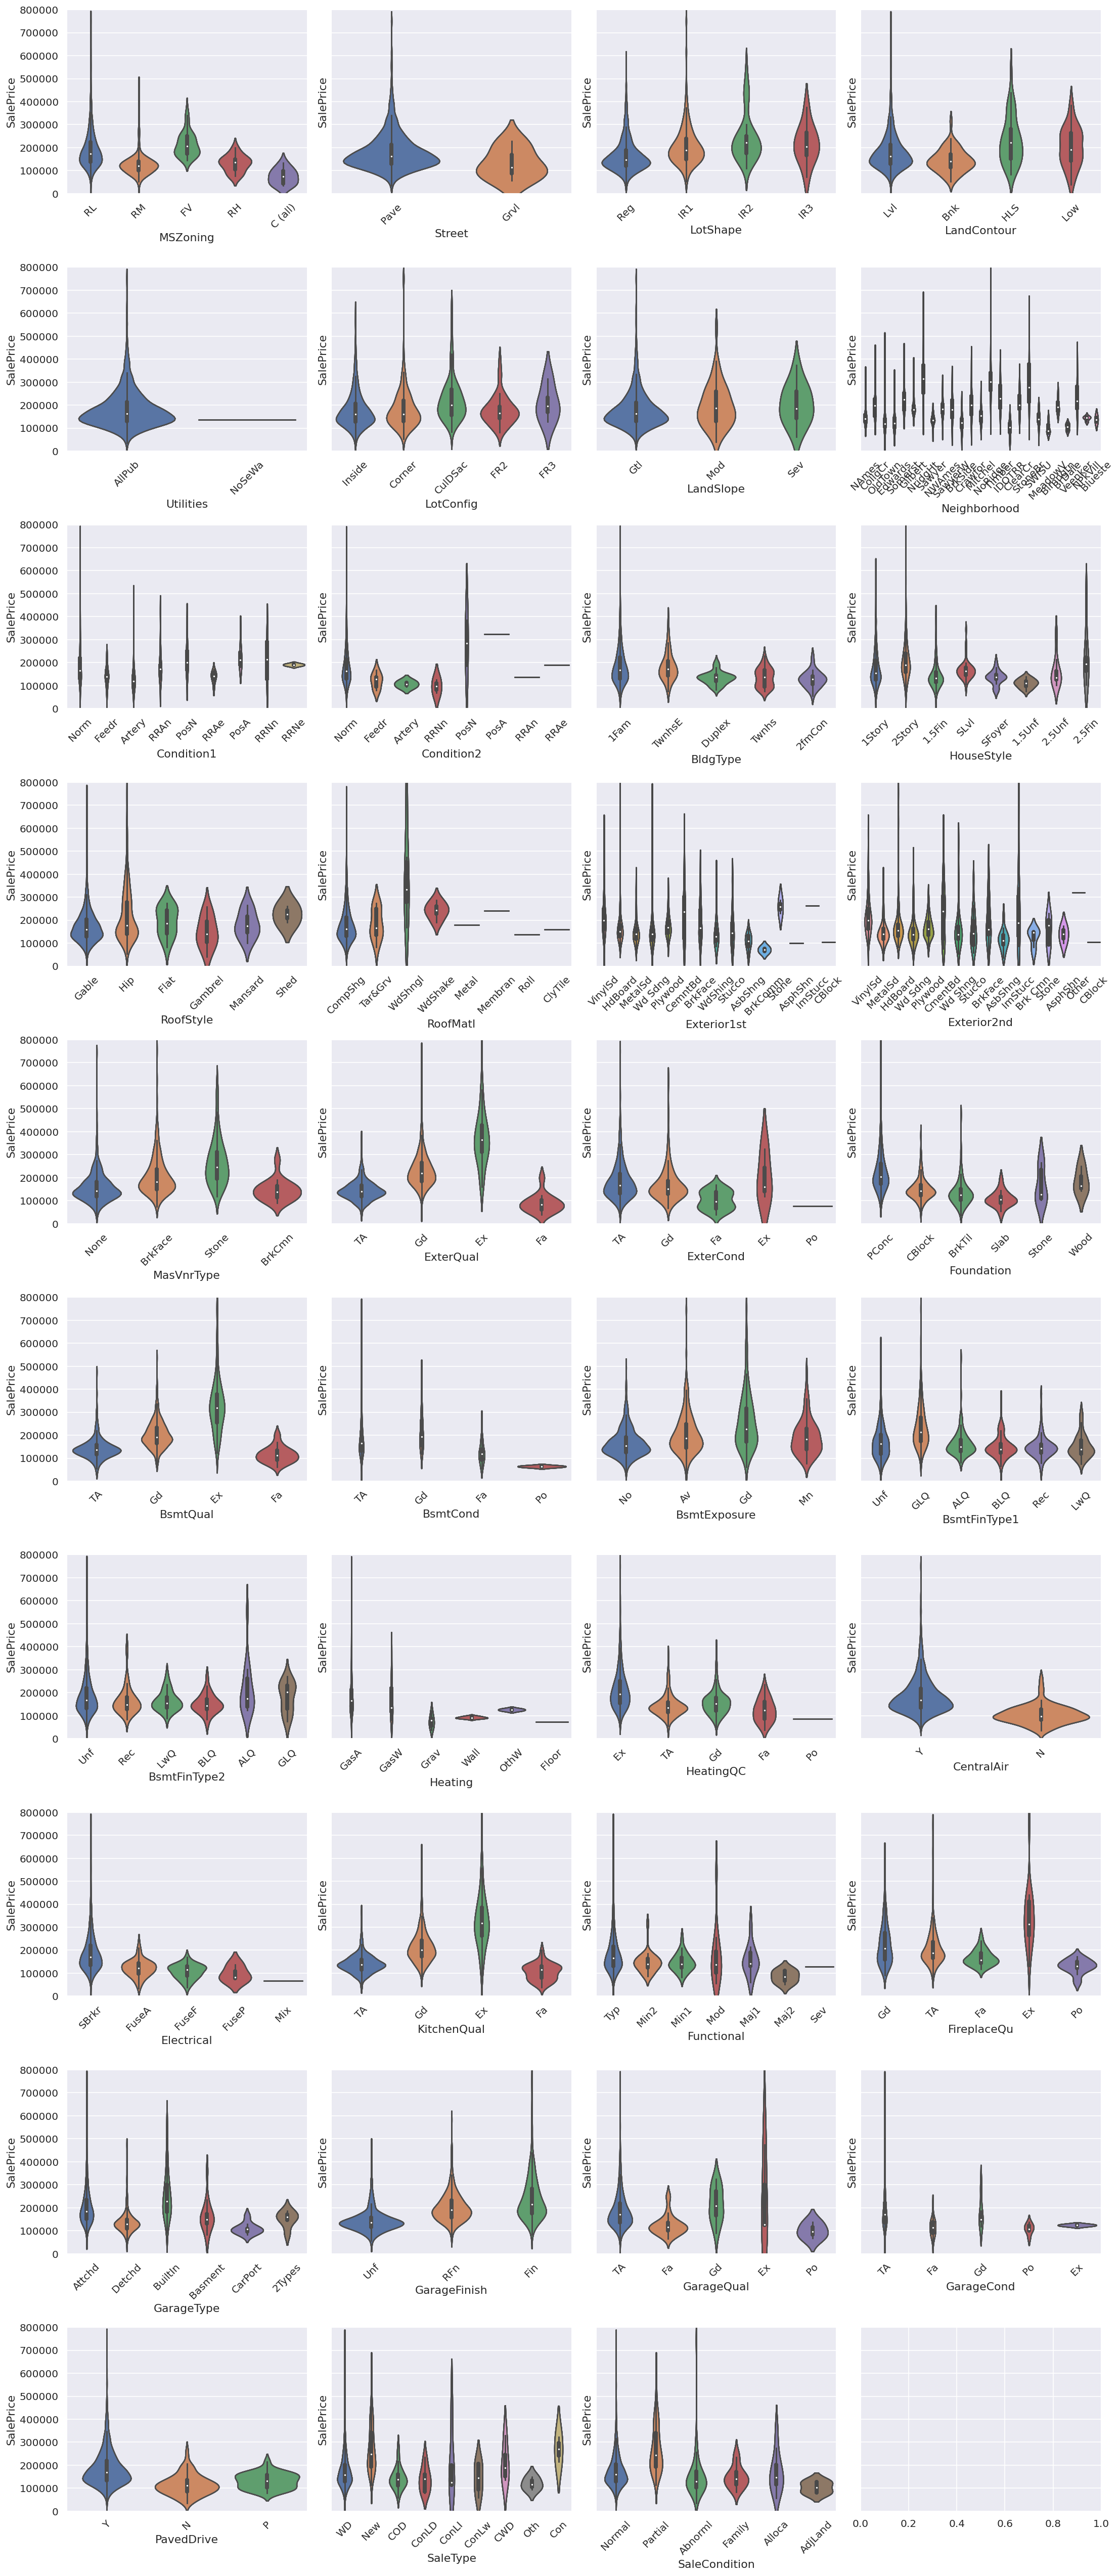

In [104]:
fig, ax = plt.subplots(nrows=ceil(len(object_cols) / 4), ncols=4, figsize=(22, 1.4*len(object_cols)), sharey=True, dpi=120)

for col, subplot in zip(object_cols, ax.flatten()):
    freq = X[col].value_counts()
    subplot.ticklabel_format(style='plain')
    plt.ylim([0, 800000])
    plt.subplots_adjust(wspace=.1,hspace=.4)
    
    for tick in subplot.get_xticklabels():
        tick.set_rotation(45)
        sns.violinplot(data=X, x=col, y=y, order=freq.index, ax=subplot)

Drop columns with most of the rows having only one category

In [105]:
# From above violin plots, 'Utilities' feature seems to have mostly one category.
# Confirm that using value_counts for each of its categories.
X.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [106]:
X_test.Utilities.value_counts()

AllPub    1457
Name: Utilities, dtype: int64

In [107]:
X.drop('Utilities',axis=1,inplace=True)
X_test.drop('Utilities',axis=1,inplace=True)

## Feature Engineering

In [108]:
# Merge the datasets so we can process them together
df = pd.concat([X, X_test])

Creating New Numerical Features

In [109]:
df1 = pd.DataFrame()  # dataframe to hold new features

# Age of House when sold
df1['Age'] = df['YrSold']-df['YearBuilt']

# Years between Remodeling and sales
df1['AgeRemodel'] = df['YrSold']-df['YearRemodAdd']

year_cols = ['YrSold','YearBuilt','AgeRemodel', 'Age']
df_1 = pd.concat([df, df1], axis=1).loc[:,year_cols]
X_1 = df_1.loc[X.index, :]

X_1.head(2)

YrSold  YearBuilt  AgeRemodel  Age
Id                                    
1     2008       2003           5    5
2     2007       1976          31   31

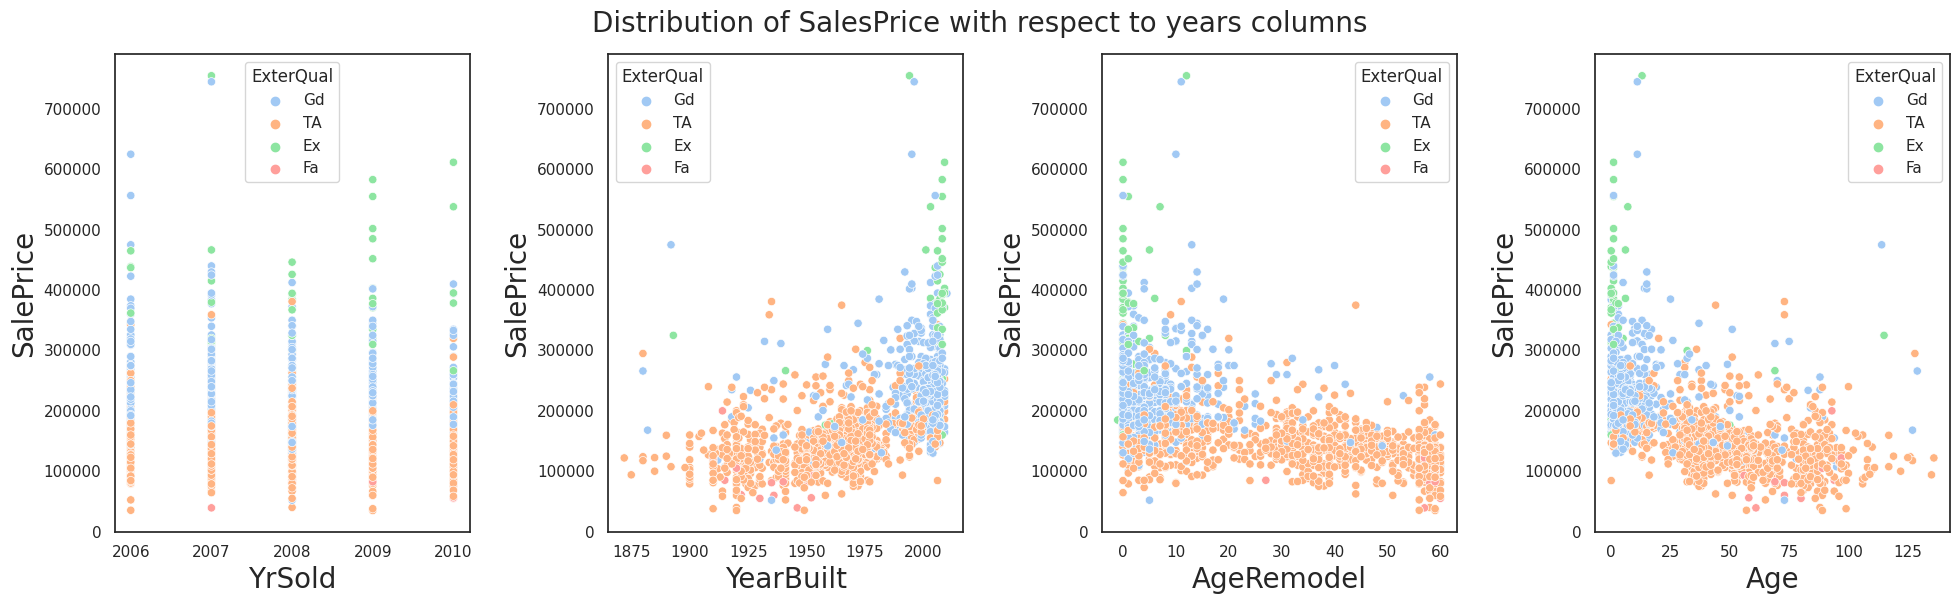

In [110]:
sns.set(style='whitegrid')
# sns.set_context("paper", rc={"font.size":20,"axes.titlesize":25,"axes.labelsize":20}) 
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
# sns.set(font_scale=1.1)
fig, ax = plt.subplots(1, 4, figsize=(20, 6), dpi=100)

# scatterplot
for col,i in zip(year_cols, [0,1,2,3]):
    sns.scatterplot(x=X_1.loc[:,col], y=y, ax=ax[i], hue=X.ExterQual, palette='pastel')

fig.tight_layout()
fig.text(0.5, 1, 'Distribution of SalesPrice with respect to years columns', size=20, ha="center", va="center")

plt.show()

In [111]:
# Correlation of year columns with SalePrice
X_1.corrwith(y)

YrSold       -0.028923
YearBuilt     0.522897
AgeRemodel   -0.509079
Age          -0.523350
dtype: float64

Creating New Boolean Features

Remodel column:
- False (for 764 houses having Remodel date same as construction date i.e. no modeling or additions)
- True (for 696 houses with modeling or additions done)

Garage column:
- False (for 81 rows having missing values in columns GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond)

Fireplace column:
- False (for 690 rows having missing values in column FireplaceQu)

Basement column:
- False (for 37 rows having missing values in columns BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2)

Masonry veneer column:
- False (for 8 rows having missing values in columns MasVnrType, MasVnrArea)

In [112]:
df2 = pd.DataFrame()  # dataframe to hold new features

df2['Remodel'] = df['YearRemodAdd']!=df['YearBuilt']
df2['Garage'] = df['GarageQual'].notnull()
df2['Fireplace'] = df['FireplaceQu'].notnull()
df2['Bsmt'] = df['BsmtQual'].notnull()
df2['Masonry'] = df['MasVnrType'].notnull()

# Converting boolean columns [False,True] into numerical columns [0,1]
df2 = df2.replace([False,True], [0,1])

df2.head(2)

Remodel  Garage  Fireplace  Bsmt  Masonry
Id                                           
1         0       1          0     1        1
2         0       1          1     1        1

Ordered Categorical Columns

Replacing ordered categories with numbers

In [113]:
object_cols = df.select_dtypes(include=['object']).columns

# Categorical Columns with number of unuque categoies in them 
df[object_cols].nunique().sort_values()

Street            2
CentralAir        2
GarageFinish      3
LandSlope         3
PavedDrive        3
BsmtQual          4
ExterQual         4
MasVnrType        4
KitchenQual       4
BsmtCond          4
BsmtExposure      4
LandContour       4
LotShape          4
HeatingQC         5
FireplaceQu       5
GarageQual        5
Electrical        5
GarageCond        5
LotConfig         5
ExterCond         5
BldgType          5
MSZoning          5
GarageType        6
Heating           6
Foundation        6
BsmtFinType1      6
RoofStyle         6
BsmtFinType2      6
SaleCondition     6
Functional        7
RoofMatl          8
HouseStyle        8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

In [114]:
ordinal_cols = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Fin' in i) or ('Cond' in i) and ('Condition' not in i)]

df.loc[:,ordinal_cols] = df.loc[:,ordinal_cols].fillna('NA')

print("Column Names: [Unique Categories in each column]")
{col:[*df[col].unique()] for col in ordinal_cols}

Column Names: [Unique Categories in each column]


{'ExterQual': ['Gd', 'TA', 'Ex', 'Fa'],
 'ExterCond': ['TA', 'Gd', 'Fa', 'Po', 'Ex'],
 'BsmtQual': ['Gd', 'TA', 'Ex', 'NA', 'Fa'],
 'BsmtCond': ['TA', 'Gd', 'NA', 'Fa', 'Po'],
 'BsmtFinType1': ['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'NA', 'LwQ'],
 'BsmtFinType2': ['Unf', 'BLQ', 'NA', 'ALQ', 'Rec', 'LwQ', 'GLQ'],
 'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
 'KitchenQual': ['Gd', 'TA', 'Ex', 'Fa', 'NA'],
 'FireplaceQu': ['NA', 'TA', 'Gd', 'Fa', 'Ex', 'Po'],
 'GarageFinish': ['RFn', 'Unf', 'Fin', 'NA'],
 'GarageQual': ['TA', 'Fa', 'Gd', 'NA', 'Ex', 'Po'],
 'GarageCond': ['TA', 'Fa', 'NA', 'Gd', 'Po', 'Ex']}

In [115]:
df.Functional.isnull().sum()

2

In [116]:
# 1] Columns with similar ordered categories [Poor<Fair<Typical/Average<Good<Excellent]
ordinal_cols1 = [i for i in object_cols if ('QC' in i) or ('Qu' in i) or ('Cond' in i) and ('Condition' not in i)]
df.loc[:,ordinal_cols1] = df.loc[:,ordinal_cols1].replace(['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], [0,1,2,3,4,5])

# 2] Columns with similar ordered categories [No Garage/Basement<Unfinished<Rough Finished<Finished,etc]
ordinal_cols2 = ['BsmtFinType1', 'BsmtFinType2']
df.loc[:,ordinal_cols2] = df.loc[:,ordinal_cols2].replace(['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], [0,1,2,3,4,5,6])

# 3] Column with ordered categories [No Basement<No Exposure<Mimimum Exposure<Average Exposure<Good Exposure]
ordinal_cols3 = ['BsmtExposure']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('NA')
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].replace(['NA', 'No', 'Mn', 'Av', 'Gd'], [0,1,2,3,4])

# 4] Column with ordered categories [Regular<Slightly irregular<Moderately Irregular<Irregular]
ordinal_cols4 = ['LotShape']
df.loc[:,ordinal_cols4] = df.loc[:,ordinal_cols4].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])

# 5] Column with ordered categories [No Garage<Unfinished<Rough Finished<Finished]
ordinal_cols5 = ['GarageFinish']
df.loc[:,ordinal_cols5] = df.loc[:,ordinal_cols5].replace(['NA', 'Unf', 'RFn', 'Fin'], [0,1,2,3])

# 6] Home functionality Column
ordinal_cols6 = ['Functional']
df.loc[:,ordinal_cols3] = df.loc[:,ordinal_cols3].fillna('Mod')
df.loc[:,ordinal_cols6] = df.loc[:,ordinal_cols6].replace(["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"], list(range(8)))

In [117]:
o_columns = ordinal_cols1+ordinal_cols2+ordinal_cols3+ordinal_cols4+ordinal_cols5+ordinal_cols6

df.loc[:,o_columns].dtypes.value_counts()

int64      14
float64     1
dtype: int64

Creating features using mathematical transformations

In [118]:
df3 = pd.DataFrame()  # dataframe to hold new features

df3["Liv_Qual"] = (df.OverallQual + df.OverallCond/3) * df.GrLivArea
df3["GarageArea_Qual"] = (df.GarageQual + df.GarageCond/3) * df.GarageArea * df.GarageCars
df3['BsmtArea_Qual'] = (df.BsmtQual * df.BsmtCond/3) * df.TotalBsmtSF
df3["LivLotRatio"] = df.GrLivArea / df.LotArea
df3["Spaciousness"] = (df['1stFlrSF'] + df['2ndFlrSF']) / df.TotRmsAbvGrd

df3.head(2)

Liv_Qual  GarageArea_Qual  BsmtArea_Qual  LivLotRatio  Spaciousness
Id                                                                         
1   14820.000000           4384.0         3424.0     0.202367    213.750000
2   10937.333333           3680.0         5048.0     0.131458    210.333333

Creating features using count

In [119]:
df4 = pd.DataFrame()

df4["PorchTypes"] = df[[
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch"]].gt(0.0).sum(axis=1)

df4.head(2)

PorchTypes
Id            
1            1
2            1

Creating features using group transforms

In [120]:
df5 = pd.DataFrame()
df5["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

df5.head(2)

MedNhbdArea
Id             
1        1504.0
2        1706.5

Creating features using feature interactions

In [121]:
df6 = pd.DataFrame()  # dataframe to hold new features

df6 = pd.get_dummies(df.BldgType, prefix="Bldg")
df6 = df6.mul(df.GrLivArea, axis=0)

Concat Created Features with Original Features

In [122]:
df.shape

(2919, 74)

In [123]:
df = pd.concat([df,df1,df2,df3,df4,df5,df6], axis=1)
df.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape LandContour  \
Id                                                                           
1           60       RL         65.0     8450   Pave         0         Lvl   
2           20       RL         80.0     9600   Pave         0         Lvl   

   LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
Id                                                                              
1     Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2        FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   

    OverallQual  ...  Fireplace  Bsmt  Masonry      Liv_Qual GarageArea_Qual  \
Id               ...                                                           
1             7  ...          0     1        1  14820.000000          4384.0   
2             6  ...          1     1        1  10937.333333          3680.0   

   BsmtArea_Qual LivLotRatio Spaciousness  PorchTypes  MedNhbdArea  Bldg_1Fam  \
Id                                                                              
1         3424.0    0.202367   213.750000           1       1504.0       1710   
2         5048.0    0.131458   210.333333           1       1706.5       1262   

   Bldg_2fmCon  Bldg_Duplex  Bldg_Twnhs  Bldg_TwnhsE  
Id                                                    
1            0            0           0            0  
2            0            0           0            0  

[2 rows x 93 columns]

In [124]:
df.shape

(2919, 93)

In [125]:
# Reform splits
X = df.loc[X.index, :]
X_test = df.loc[X_test.index, :]

print(X.shape,X_test.shape,sep='\n')

(1460, 93)
(1459, 93)


## Data Visualization

In [126]:
X_y = X.copy()
X_y['SalesPrice'] = y

X_y.head(2)

MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape LandContour  \
Id                                                                           
1           60       RL         65.0     8450   Pave         0         Lvl   
2           20       RL         80.0     9600   Pave         0         Lvl   

   LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
Id                                                                              
1     Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2        FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   

    OverallQual  ...  Bsmt  Masonry      Liv_Qual GarageArea_Qual  \
Id               ...                                                
1             7  ...     1        1  14820.000000          4384.0   
2             6  ...     1        1  10937.333333          3680.0   

   BsmtArea_Qual LivLotRatio Spaciousness PorchTypes  MedNhbdArea  Bldg_1Fam  \
Id                                                                             
1         3424.0    0.202367   213.750000          1       1504.0       1710   
2         5048.0    0.131458   210.333333          1       1706.5       1262   

    Bldg_2fmCon Bldg_Duplex  Bldg_Twnhs  Bldg_TwnhsE  SalesPrice  
Id                                                                
1             0           0           0            0      208500  
2             0           0           0            0      181500  

[2 rows x 94 columns]

Create a function to automate plotting 4 types of plot for a single numerical variable.

In [127]:
def univariate_numerical_plot(df, x):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi=100)
    
    # 0) histogram
    sns.histplot(data=df, x=x, kde=True, ax=ax[0], bins=min(df[x].nunique(),10), kde_kws={'bw_adjust':3})
    sns.despine(bottom=True, left=True)
    ax[0].set_title('histogram')
    ax[0].set_xlabel(xlabel=x)
    
    # 1) box plot
    sns.boxplot(data=df, x=x, ax=ax[1])
    ax[1].set_title('boxplot')
    ax[1].set_ylabel(ylabel=x)
    
    # 2) scatterplot
    sns.scatterplot(x=df[x], y=y, ax=ax[2], hue=y ,palette='coolwarm')
    plt.legend([],[], frameon=False)
    
    # To add border
    fig.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=0.8)
    fig.patch.set_linewidth(10)
    fig.patch.set_edgecolor('cornflowerblue')
    
    fig.tight_layout()
    fig.text(0.5, 1, f'Distribution of {x}', size=25, ha="center", va="center")
    
    plt.show()

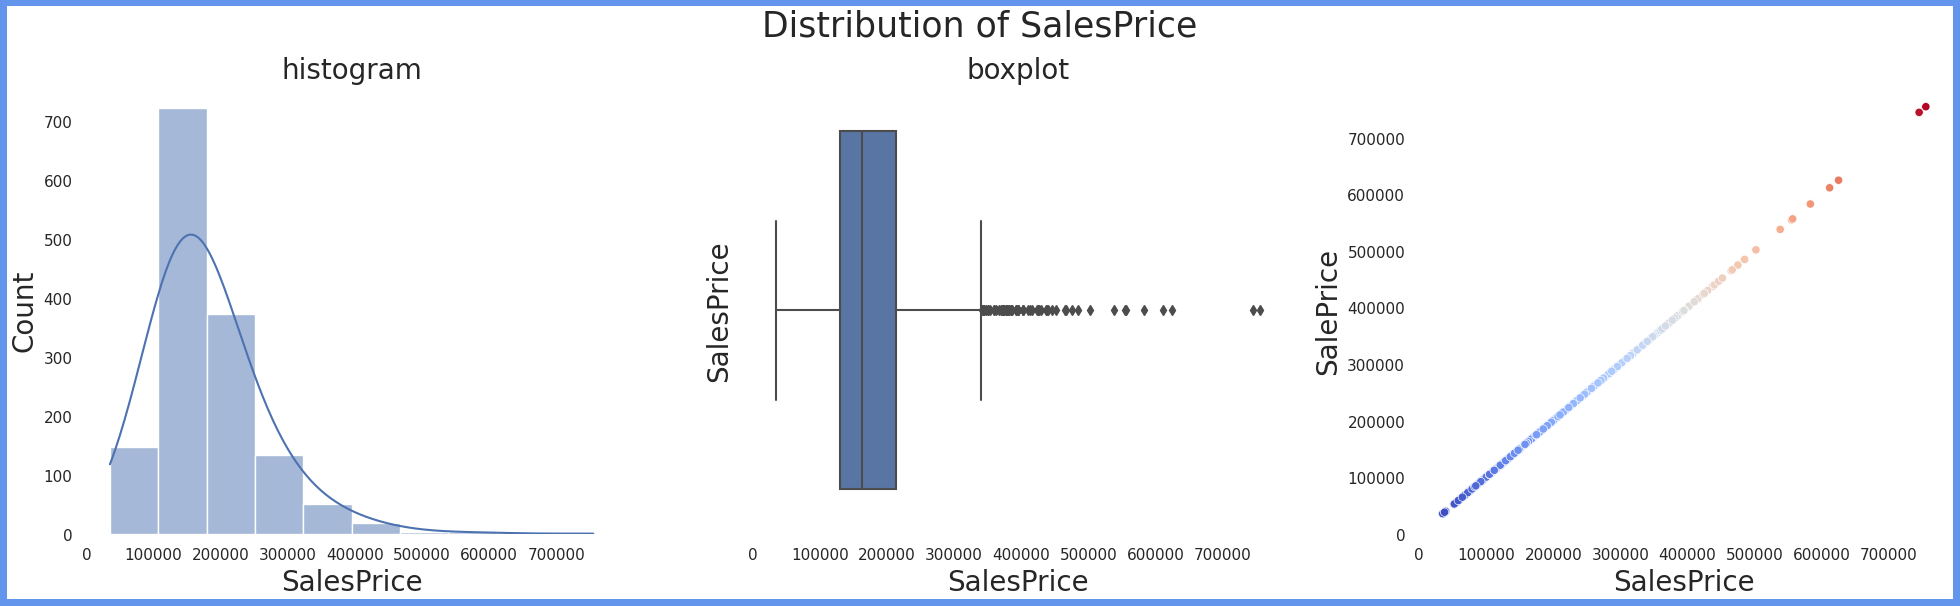

In [128]:
# Check distribution of target variable
univariate_numerical_plot(X_y,'SalesPrice')

As many features are available for plotting, we won't plot all of them. We can focus on features having higher correaltion (which is calculated in the section below)

Correlation of X with y

In [129]:
for name in X.select_dtypes("number"):
    X[name] = X[name].fillna(0)

def make_mi_scores(X, y):
    X = X.copy()
    # All discrete features should now have integer dtypes
    # discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X.select_dtypes('number'), y, random_state=0)
    mi_scores = pd.DataFrame(mi_scores.round(2), columns=["MI_Scores"], index=X.select_dtypes('number').columns)
    return mi_scores

In [130]:
mi_scores = make_mi_scores(X, y)
linear_corr = pd.DataFrame(X.corrwith(y).round(2), columns=['Lin_Correlation'])

corr_with_price = pd.concat([mi_scores, linear_corr], axis=1)
corr_with_price = corr_with_price.sort_values('MI_Scores',ascending=False)

corr_with_price

MI_Scores  Lin_Correlation
Liv_Qual              0.73             0.82
OverallQual           0.55             0.79
BsmtArea_Qual         0.48             0.72
GrLivArea             0.48             0.71
MedNhbdArea           0.48             0.66
Bldg_1Fam             0.44             0.57
GarageArea_Qual       0.39             0.69
TotalBsmtSF           0.37             0.61
GarageCars            0.37             0.64
GarageArea            0.36             0.62
YearBuilt             0.36             0.52
KitchenQual           0.34             0.66
Age                   0.33            -0.52
BsmtQual              0.33             0.59
ExterQual             0.31             0.68
1stFlrSF              0.31             0.61
MSSubClass            0.27            -0.08
AgeRemodel            0.26            -0.51
FullBath              0.26             0.56
GarageFinish          0.26             0.55
GarageYrBlt           0.26             0.26
Spaciousness          0.25             0.55
YearRemodAdd          0.24             0.51
TotRmsAbvGrd          0.22             0.53
LotFrontage           0.21             0.21
FireplaceQu           0.21             0.52
2ndFlrSF              0.20             0.32
Fireplace             0.17             0.47
Fireplaces            0.17             0.47
HeatingQC             0.17             0.43
LotArea               0.16             0.26
BsmtFinType1          0.15             0.30
OpenPorchSF           0.15             0.32
BsmtFinSF1            0.15             0.39
BsmtUnfSF             0.12             0.21
OverallCond           0.12            -0.08
WoodDeckSF            0.11             0.32
PorchTypes            0.11             0.41
LivLotRatio           0.09            -0.00
BsmtExposure          0.09             0.37
GarageQual            0.09             0.27
GarageCond            0.09             0.26
MasVnrArea            0.09             0.47
BedroomAbvGr          0.08             0.17
LotShape              0.08             0.27
HalfBath              0.07             0.28
Garage                0.05             0.24
Bldg_TwnhsE           0.05             0.04
KitchenAbvGr          0.04            -0.14
BsmtCond              0.04             0.21
BsmtFullBath          0.03             0.23
EnclosedPorch         0.03            -0.13
Bldg_Duplex           0.03            -0.10
Remodel               0.03            -0.02
Bsmt                  0.03             0.15
BsmtFinType2          0.02            -0.01
Bldg_Twnhs            0.02            -0.08
Masonry               0.02            -0.05
Bldg_2fmCon           0.01            -0.08
BsmtHalfBath          0.01            -0.02
ExterCond             0.01             0.02
ScreenPorch           0.01             0.11
LowQualFinSF          0.01            -0.03
MiscVal               0.01            -0.02
YrSold                0.00            -0.03
MoSold                0.00             0.05
PoolArea              0.00             0.09
3SsnPorch             0.00             0.04
BsmtFinSF2            0.00            -0.01
Functional            0.00             0.11

Distribution of top 5 features correlated with Sales Price

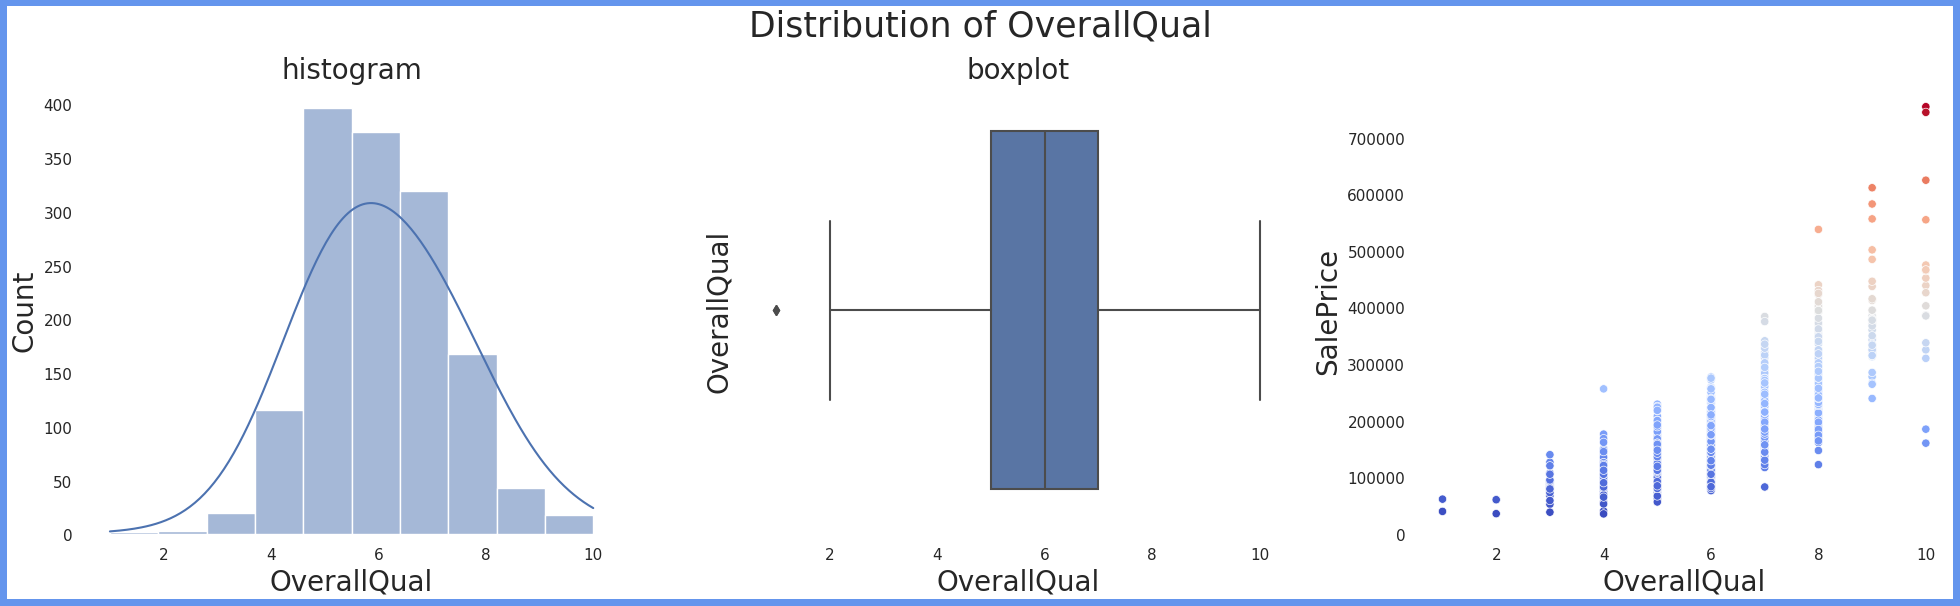

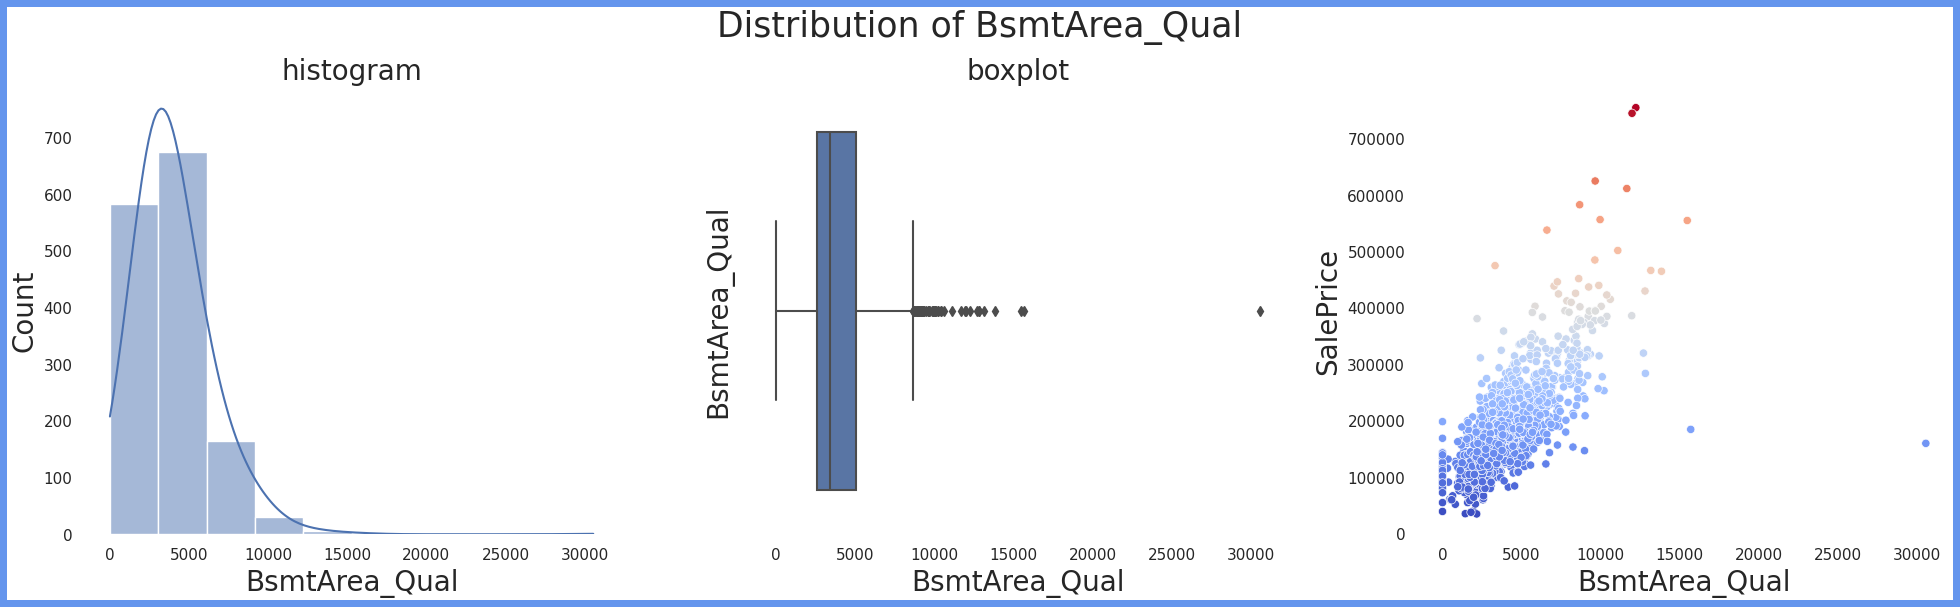

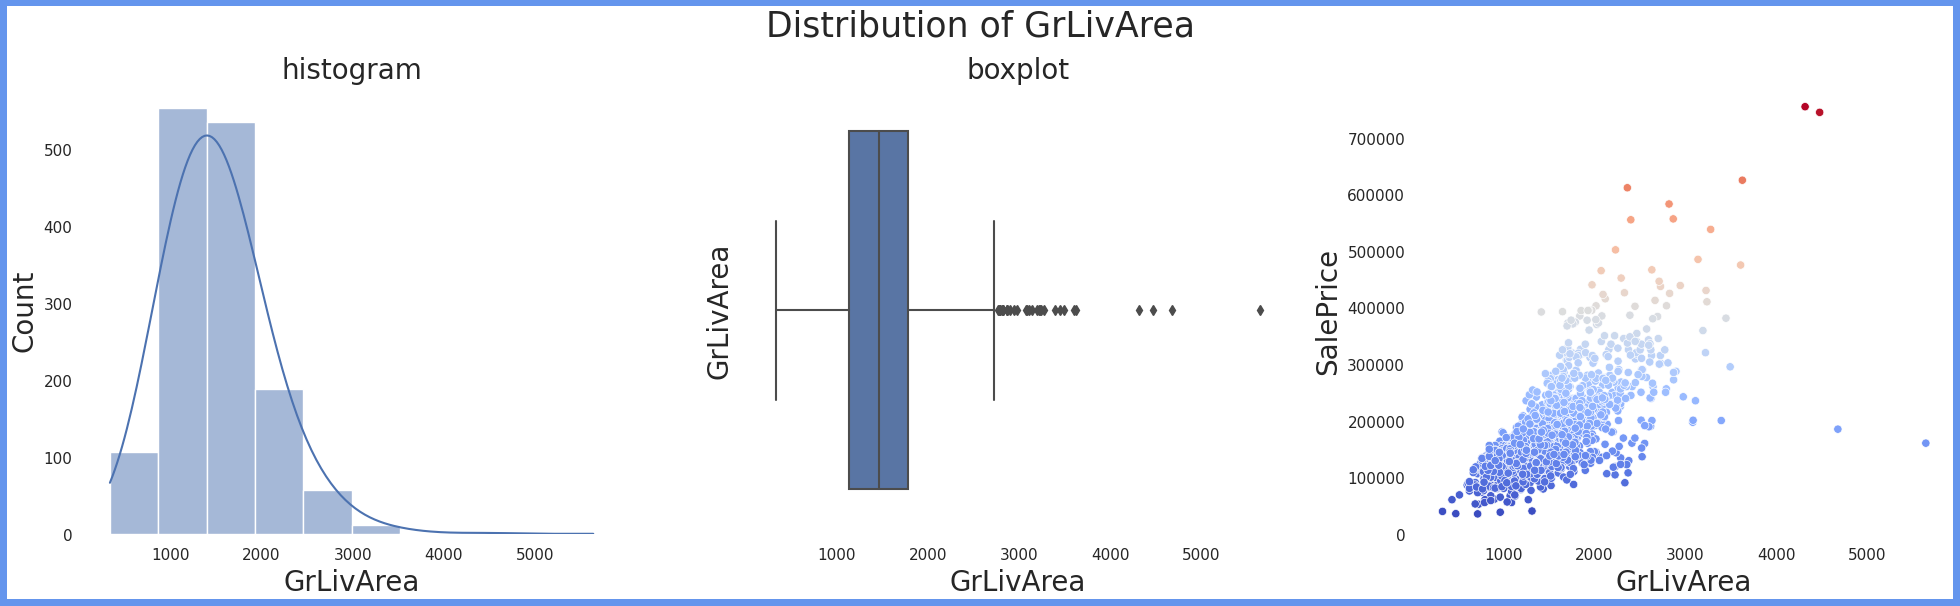

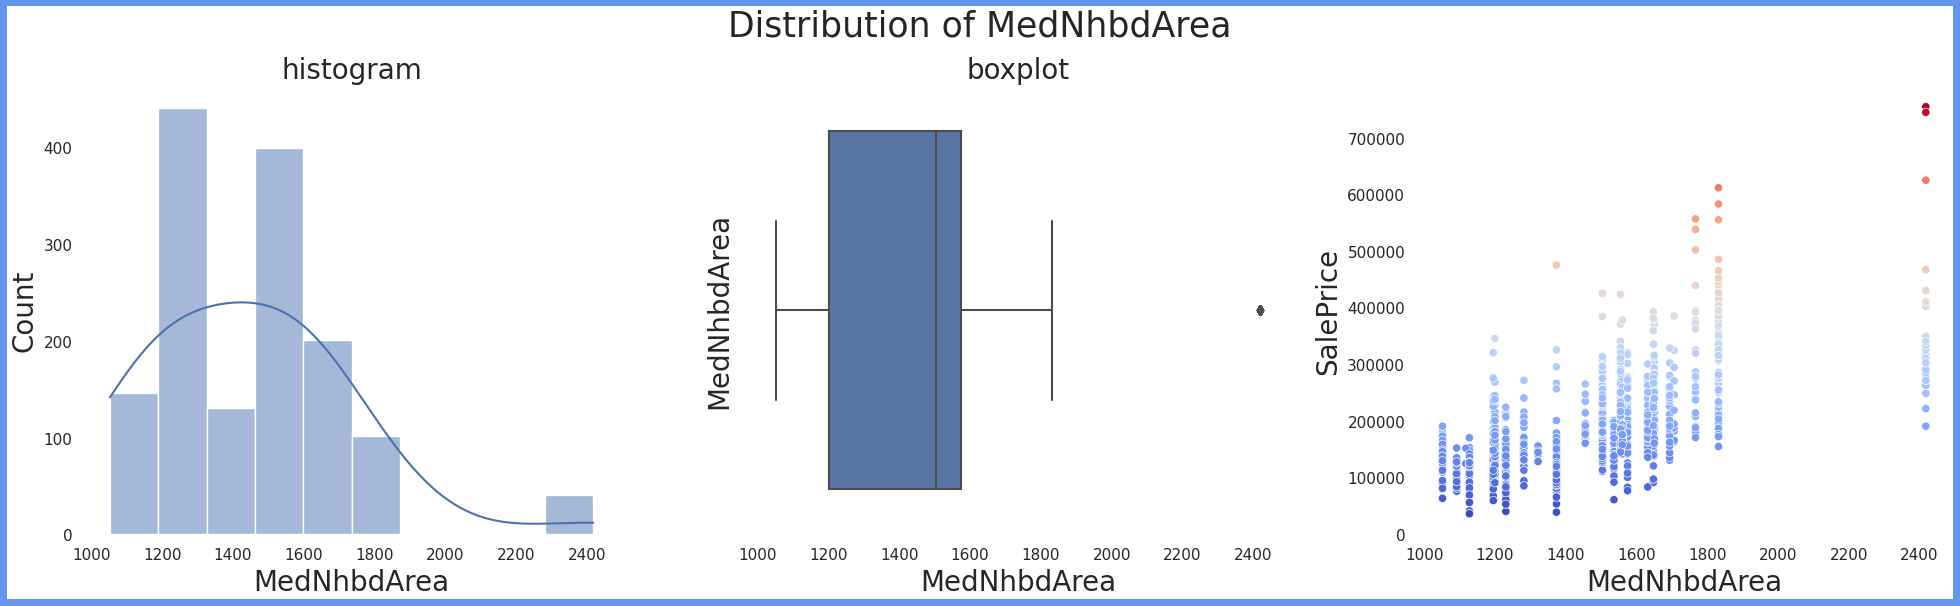

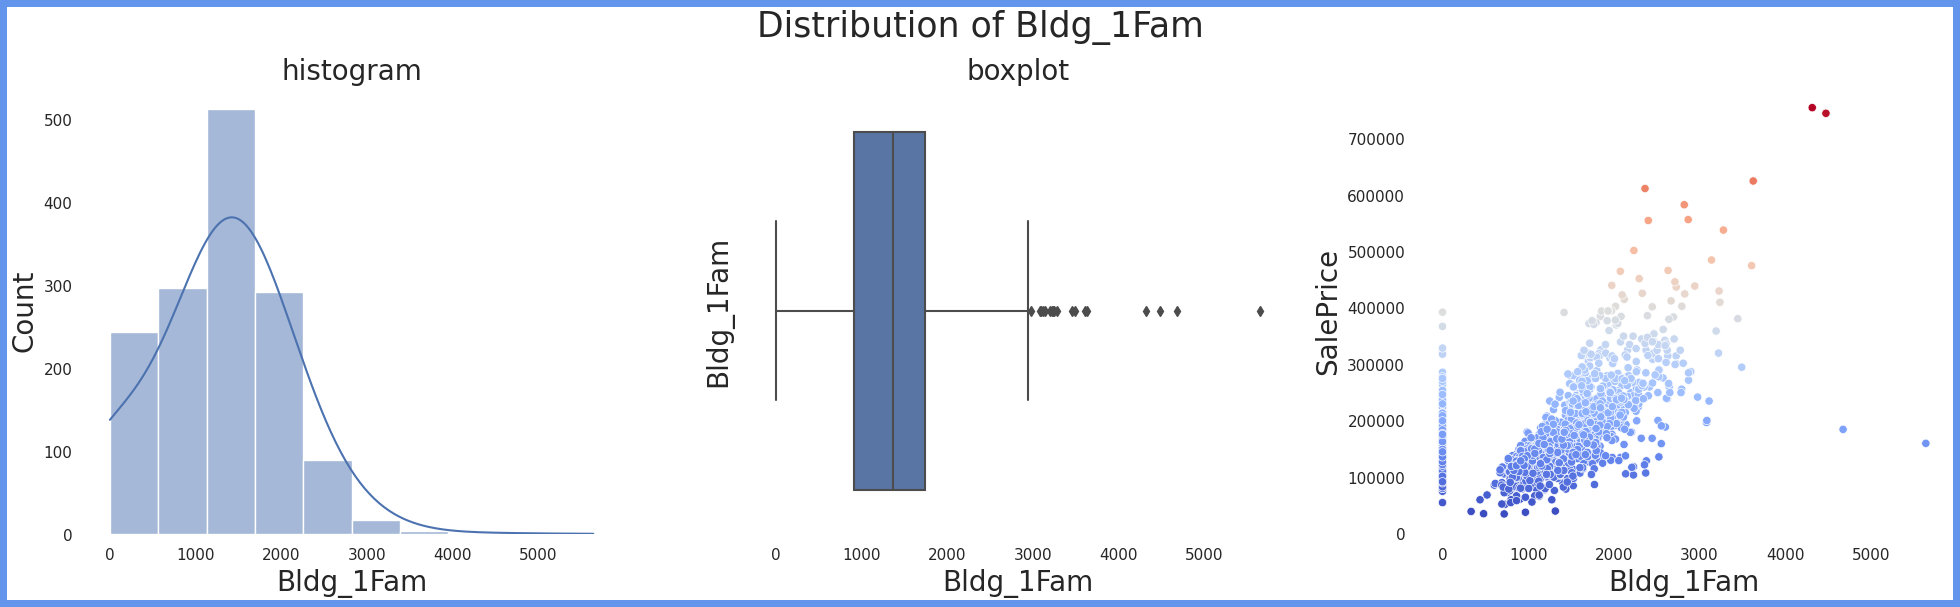

In [131]:
top_features = corr_with_price.index[1:6]

for feature in top_features:
    univariate_numerical_plot(X,feature)

## Feature Section

In [132]:
X.dtypes.value_counts()

int64      52
object     23
float64    18
dtype: int64

In [133]:
# Categorical columns with low cardinality (number of unique values in a column)
categorical_cols = [cname for cname in X.select_dtypes(["object","category","bool"]).columns
                    if X[cname].nunique() < 30]

# Numerical columns with large correlation with Sales Price
numerical_cols = [cname for cname in X.select_dtypes(['int64', 'float64']).columns
                  if abs(corr_with_price.MI_Scores[cname]) > 0.01]

# Keep selected columns only
selected_cols = categorical_cols + numerical_cols
X = X[selected_cols]
X_test = X_test[selected_cols]

Selected Features

In [134]:
# Out of available feature, following number of features will be used for regression
print(len(categorical_cols),len(numerical_cols))

23 58


In [135]:
X.dtypes.value_counts()

int64      43
object     23
float64    15
dtype: int64

In [136]:
# To see which object columns were selected according to max cardinality condition 
# and which numerical columns were selected according to min correlation condition
info = pd.DataFrame(X.dtypes, columns=['Dtype'])
info['Unique'] = X.nunique().values
info['Null'] = X.isnull().sum().values
info.sort_values(['Dtype', 'Unique'])

Dtype  Unique  Null
Remodel            int64       2     0
Garage             int64       2     0
Fireplace          int64       2     0
Bsmt               int64       2     0
Masonry            int64       2     0
HalfBath           int64       3     0
LotShape           int64       4     0
ExterQual          int64       4     0
FullBath           int64       4     0
KitchenAbvGr       int64       4     0
KitchenQual        int64       4     0
Fireplaces         int64       4     0
GarageFinish       int64       4     0
PorchTypes         int64       4     0
BsmtQual           int64       5     0
BsmtCond           int64       5     0
BsmtExposure       int64       5     0
HeatingQC          int64       5     0
FireplaceQu        int64       6     0
GarageQual         int64       6     0
GarageCond         int64       6     0
BsmtFinType1       int64       7     0
BsmtFinType2       int64       7     0
BedroomAbvGr       int64       8     0
OverallCond        int64       9     0
OverallQual        int64      10     0
TotRmsAbvGrd       int64      12     0
MSSubClass         int64      15     0
Bldg_Twnhs         int64      25     0
Bldg_Duplex        int64      42     0
YearRemodAdd       int64      61     0
AgeRemodel         int64      62     0
Bldg_TwnhsE        int64      87     0
YearBuilt          int64     112     0
EnclosedPorch      int64     120     0
Age                int64     122     0
OpenPorchSF        int64     202     0
WoodDeckSF         int64     274     0
2ndFlrSF           int64     417     0
1stFlrSF           int64     753     0
Bldg_1Fam          int64     788     0
GrLivArea          int64     861     0
LotArea            int64    1073     0
BsmtFullBath     float64       4     0
GarageCars       float64       5     0
MedNhbdArea      float64      24     0
GarageYrBlt      float64      98     0
LotFrontage      float64     111     0
MasVnrArea       float64     327     0
GarageArea       float64     441     0
GarageArea_Qual  float64     530     0
BsmtFinSF1       float64     637     0
TotalBsmtSF      float64     721     0
BsmtUnfSF        float64     780     0
BsmtArea_Qual    float64     896     0
Spaciousness     float64     990     0
Liv_Qual         float64    1280     0
LivLotRatio      float64    1423     0
Street            object       2     0
CentralAir        object       2     0
LandSlope         object       3     0
PavedDrive        object       3     0
LandContour       object       4     0
MasVnrType        object       4     8
MSZoning          object       5     0
LotConfig         object       5     0
BldgType          object       5     0
Electrical        object       5     1
RoofStyle         object       6     0
Foundation        object       6     0
Heating           object       6     0
GarageType        object       6    81
SaleCondition     object       6     0
Condition2        object       8     0
HouseStyle        object       8     0
RoofMatl          object       8     0
Condition1        object       9     0
SaleType          object       9     0
Exterior1st       object      15     0
Exterior2nd       object      16     0
Neighborhood      object      25     0

In [137]:
show_null_values(X, X_test)

Total miising values:
Train Data     90
Test Data     428
dtype: int64


Train Data  Test Data
GarageType               81         76
MasVnrType                8         16
Electrical                1          0
LotFrontage               0        227
GarageYrBlt               0         78
MasVnrArea                0         15
MSZoning                  0          4
BsmtFullBath              0          2
Exterior1st               0          1
Exterior2nd               0          1
SaleType                  0          1
BsmtFinSF1                0          1
BsmtUnfSF                 0          1
TotalBsmtSF               0          1
GarageCars                0          1
GarageArea                0          1
GarageArea_Qual           0          1
BsmtArea_Qual             0          1

## Model Section

Preprocessing

In [138]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant',fill_value=0)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [139]:
# Create object of class XGBRegressor
xgb = XGBRegressor(eval_metric='rmse')

# Bundle preprocessing and modeling code in a pipeline
regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb)
                     ])

Visualize Pipeline

In [140]:
from sklearn import set_config
set_config(display='diagram')

regressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'LotShape',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'ExterQual',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'BsmtFinSF1',
                                                   'BsmtFinType2', 'BsmtUnfSF',
                                                   'TotalBsmt...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'LandContour', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'Foundation',
                                                   'Heating', 'CentralAir',
                                                   'Electrical', 'GarageType',
                                                   'PavedDrive', 'SaleType',
                                                   'SaleCondition'])])),
                ('model', XGBRegressor(eval_metric='rmse'))])

Grid Search & Cross Validation

In [141]:
param_grid = [
    {'model__subsample': [0.5], 'model__n_estimators': [1400], 
     'model__max_depth': [4, 5], 'model__learning_rate': [0.02],
     'model__colsample_bytree': [0.4], 'model__colsample_bylevel': [0.4],
     'model__reg_alpha':[1], 'model__reg_lambda': [1], 'model__min_child_weight':[2]}
]
grid_search = GridSearchCV(regressor, param_grid, cv=3, verbose=1, scoring='neg_root_mean_squared_error')

## Training and Testing Model

In [142]:
grid_search.fit(X, np.log(y));

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[09:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [143]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.953515      0.042001         0.043303        0.001085   
1       3.388499      0.060029         0.052239        0.004931   

  param_model__colsample_bylevel param_model__colsample_bytree  \
0                            0.4                           0.4   
1                            0.4                           0.4   

  param_model__learning_rate param_model__max_depth  \
0                       0.02                      4   
1                       0.02                      5   

  param_model__min_child_weight param_model__n_estimators  \
0                             2                      1400   
1                             2                      1400   

  param_model__reg_alpha param_model__reg_lambda param_model__subsample  \
0                      1                       1                    0.5   
1                      1                       1                    0.5   

                                              params  split0_test_score  \
0  {'model__colsample_bylevel': 0.4, 'model__cols...          -0.112159   
1  {'model__colsample_bylevel': 0.4, 'model__cols...          -0.112044   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0          -0.132040          -0.119981        -0.121393        0.008178   
1          -0.132498          -0.120375        -0.121639        0.008398   

   rank_test_score  
0                1  
1                2

Best Parameters:

In [144]:
grid_search.best_params_

{'model__colsample_bylevel': 0.4,
 'model__colsample_bytree': 0.4,
 'model__learning_rate': 0.02,
 'model__max_depth': 4,
 'model__min_child_weight': 2,
 'model__n_estimators': 1400,
 'model__reg_alpha': 1,
 'model__reg_lambda': 1,
 'model__subsample': 0.5}

Best score in grid search


Public leader board will have little less RMSLE than that of on validation data, because below error is on validation data when model is trained/fitted on 67% of the training data because of 3-fold cross validation. Public leaderboard will have error on test data when model is retrained/refitted on 100% of the training data.

In [145]:
print("RMSLE on training data:",round(-grid_search.score(X, np.log(y)),4))
print("RMSLE on validation data:",round(-grid_search.best_score_,4))

RMSLE on training data: 0.0786
RMSLE on validation data: 0.1214


To avoid overfitting:
Difference in the performance (Root Mean Squared Log Error) of model on training data and validation data should be minimized.

Generate test predictions

In [146]:
y_preds = np.exp(grid_search.predict(X_test))

Save output to CSV file

In [147]:
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': y_preds.round()})
output.to_csv('submission.csv', index=False)

Check output format and submit results

In [148]:
output.head(2)

Id  SalePrice
0  1461   123884.0
1  1462   161468.0